In [27]:
!pip install pytorch torchvision
!pip install transformers

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-no

# Import Libraries

In [56]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import torch
from torch import optim
from tqdm.notebook import tqdm
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Data Understanding

Dataset from :  https://www.kaggle.com/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification

In [29]:
spam_df = pd.read_csv("https://raw.githubusercontent.com/RandyTunru/PersonalDatasets/master/SpamEmailDataset/spam.csv")

In [30]:
spam_df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [31]:
spam_df.shape

(5572, 2)

<Axes: xlabel='Category', ylabel='count'>

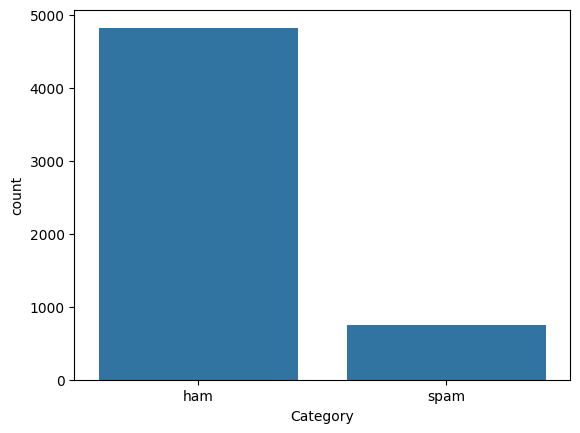

In [32]:
sns.barplot(spam_df.Category.value_counts())

Memeriksa jumlah data pada setiap kelas

Text(0.5, 0, 'Word Length')

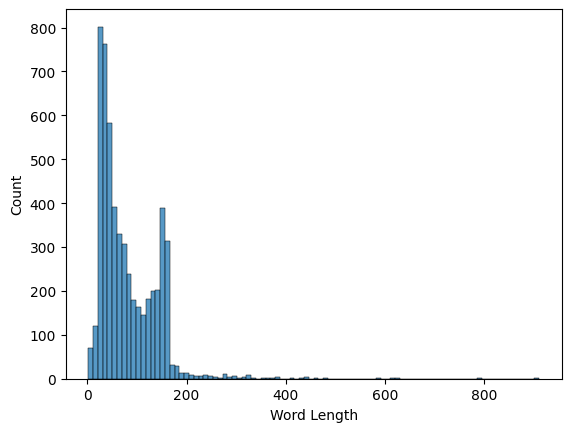

In [57]:
sns.histplot(spam_df['Message'].str.len())

plt.xlabel('Word Length')

Memeriksa panjang dari teks pada dataframe

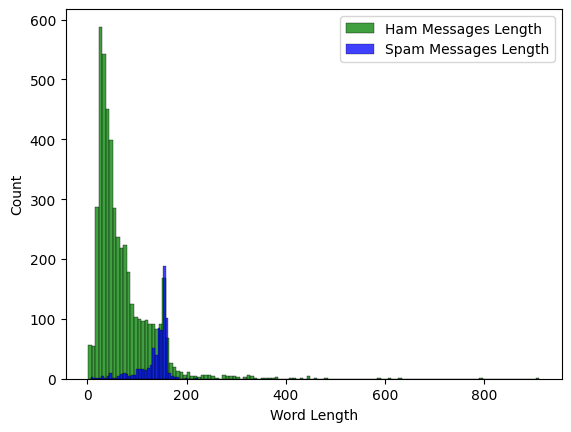

In [35]:
sns.histplot(spam_df['Message'][spam_df['Category'] == "ham"].str.len(), color='green', label='Ham Messages Length')
sns.histplot(spam_df['Message'][spam_df['Category'] == "spam"].str.len(), color='blue', label='Spam Messages Length')

plt.xlabel('Word Length')
plt.ylabel('Count')
plt.legend()

plt.show()

Melihat perbandingan panjang message pada kelas 'Spam' dan 'Ham'

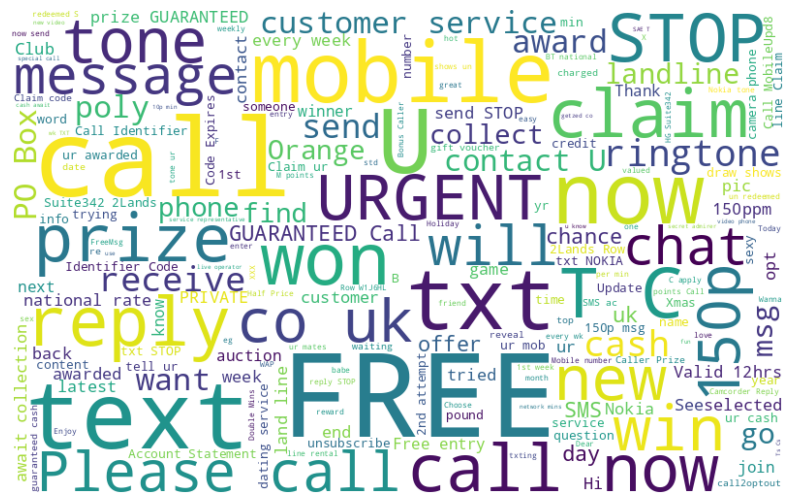

In [36]:
def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in spam_df["Message"][spam_df.Category == "spam"]])
wordCloud(all_words)

Melihat kata-kata yang sering muncul pada message berjenis spam, dapat dilihat bahwa message spam cenderung memberi iming iming mendapatkan hadiah dan membuat urgensi untuk melakukan sesuatu

# Model and Fine Tuning

In [37]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [38]:
# Define RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model RoBERTa base dengan num_labels=2 karena target kelas kita ada 2

In [39]:
set_seed(2024)

In [40]:
count_param(model)

124647170

In [41]:
# Define PyTorch Dataset
class SpamDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx], 'labels': self.labels[idx]}

Mendefinisikan Class Dataset untuk data yang digunakan pada model

In [42]:
LABEL2INDEX = {'ham': 0, 'spam': 1}
INDEX2LABEL = {0: 'ham', 1: 'spam'}

Meinisialisasi dictionary untuk mengubah kelas kita dari label ke indeks dan sebaliknya

In [43]:
# Load pre-trained RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading Tokenizer yang dapat digunakan untuk model

In [44]:
texts = spam_df.Message.tolist()
labels = spam_df.Category.apply(lambda lab: LABEL2INDEX[lab]).tolist()

In [45]:
# Tokenize input texts
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")

# Split dataset into train and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs['input_ids'], labels, test_size=0.2, random_state=42
)

train_dataset = SpamDataset(train_inputs, train_labels)

val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    test_inputs, test_labels, test_size=0.5, random_state=42
)

val_dataset = SpamDataset(val_inputs, val_labels)
test_dataset = SpamDataset(test_inputs, test_labels)

Melakukan tokenisasi sekaligus train test split menjadi 3 bagian data yaitu train, validasi, dan test

In [46]:
# Training settings
batch_size = 32
num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Mendefinisikan parameter batch_size dan jumlah epoch serta menginisialisasi Data Loader, sekaligus menentukan optimizer yang akan digunakan

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Memeriksa apakah device memiliki GPU, jika tidak maka akan menggunakan CPU

In [48]:
# Train Loop
for epoch in range(num_epochs):
    model.train()
    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for batch in train_pbar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Update the progress bar with the current loss and learning rate
        train_pbar.set_description(("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            loss.item(), get_lr(optimizer))))

  0%|          | 0/140 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

Proses training dilakukan dalam 5 Epoch, menggunakan tqdm untuk melihat progress selama training sekaligus memperlihatkan loss dan learning rate selama proses training

In [49]:
def get_model_metrics(list_hyp, list_labels):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

Mendefinisikan fungsi untuk menghitung metrik evaluasi

In [50]:
# Evaluation loop
model.eval()
list_hyp = []
list_label = []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=labels)

    predicted_probabilities = torch.softmax(outputs.logits, dim=1)
    predicted_labels = torch.argmax(predicted_probabilities, dim=1)

    list_hyp.extend(predicted_labels.tolist())
    list_label.extend(labels.tolist())

    metrics = get_model_metrics(list_hyp, list_label)
    pbar.set_description("VALID LOSS:{:.4f} {}".format(outputs.loss.item(), metrics_to_string(metrics)))

metrics = get_model_metrics(list_hyp, list_label)
print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),outputs.loss.item(), metrics_to_string(metrics)))

  0%|          | 0/18 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.0102 ACC:0.99 F1:0.98 REC:0.98 PRE:0.98


Melakukan evaluasi terhadap model dengan metrik Accuracy, F1-Score, Recall, dan Precision

In [51]:
model.eval()

input_ids = test_dataset[20]['input_ids'].unsqueeze(0).to(device)  # Add batch dimension and move to device

outputs = model(input_ids)

predicted_probabilities = torch.softmax(outputs.logits, dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

original_text = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)

print("Original text:", original_text)
print("Predicted label:", INDEX2LABEL[predicted_labels.item()])

Original text: Sleeping nt feeling well
Predicted label: ham


Melakuka Prediksi terhadap data testing yang belum pernah dijumpai oleh model

In [55]:
file_path = 'SpamEmailDetection_withRoBERTa_stateDictionary.pth'

# Save the model
torch.save(model.state_dict(), file_path)